# Running Order Scheduling

In this section, we will detail the running order scheduling in `BrainPy`, and tell you how to customize the running order of objects in a network. 

In [1]:
import brainpy as bp

## Step function

In BrainPy, the basic concept for neurodynamics simulation is the `step function`. For example, in a customized `brainpy.NeuGroup`, 

In [2]:
class HH(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH, self).__init__(size=size, **kwargs)
        
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.zeros(self.num)

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt

    def update(self, _t, _i, _dt):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

three step functions are included:

- `update` step function (explicitly defined by users)
- `monitor` step function (implicitly generated by BrainPy if users require monitors when `HH` initialization: `group = HH(..., monitors=['V', ...])`)
- `input` step function (implicitly generated by BrainPy if users give inputs: `group.run(..., inputs=('input', 10.))`)

We can inspect this by:

In [3]:
group1 = HH(1, monitors=['V', 'input'])

hh_schedule = tuple(group1.schedule())
hh_schedule

('input', 'update', 'monitor')

Later, BrainPy will update the step functions by the running order of `hh_schedule`:

In [4]:
group1.build(duration=100, inputs=('input', 10.), show_code=True)

The input to a new key "input" in <__main__.HH object at 0x00000141930F2550>.
def input_step(_i):
  NG1.input += NG1._input_data_of_input
{'NG1': <__main__.HH object at 0x00000141930F2550>}

def monitor_step(_i, _t):
  NG1.mon.V[_i] = NG1.V
  NG1.mon.V_t[_i] = _t
  NG1.mon.input[_i] = NG1.input
  NG1.mon.input_t[_i] = _t
{'NG1': <__main__.HH object at 0x00000141930F2550>,
 'ops': <module 'brainpy.backend.ops' from '../..\\brainpy\\backend\\ops\\__init__.py'>}

def run_func(_t, _i, _dt):
  NG1.input_step(_i)
  NG1.update(_t, _i, _dt)
  NG1.monitor_step(_i, _t)
{'NG1': <__main__.HH object at 0x00000141930F2550>}



<function run_func(_t, _i, _dt)>

As you can see, in the final `run_func(_t, _i, _dt)`, the running order of step functions is in line with the `hh_schedule`.

## Customize `schedule()`

Fortunately, BrainPy allows users to customize the running schedule. Let's take the above `HH` class as the illustrating example:

In [5]:
class HH2(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH2, self).__init__(size=size, **kwargs)
        
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.zeros(self.num)

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4.0) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt

    def update(self, _t, _i, _dt):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0
        
    def schedule(self):
        return ('monitor',) + tuple(self.steps.keys()) + ('input', )

Here, we define `HH2` class. What's different from the above `HH` model is that the customized `schedule()` function makes the `monitor` function and the user-defined `steps` functions run first, then run the `input` function. 

In [6]:
group2 = HH2(1, monitors=['V', 'input'])

group2.schedule()

('monitor', 'update', 'input')

The advantage of such scheduling arrangement is that users can monitor the total synaptic inputs at each time step:

In [7]:
import numpy as np

duration = 100
random_inputs = np.random.random(int(duration / bp.backend.get_dt())) * 10.

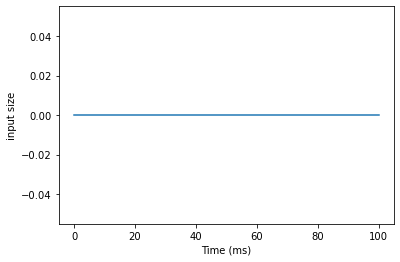

In [8]:
group1.run(duration, inputs=('input', random_inputs))

bp.visualize.line_plot(group1.mon.input_t, group1.mon.input,
                       ylabel='input size', show=True)

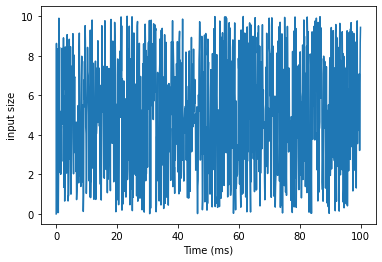

In [9]:
group2.run(duration, inputs=('input', random_inputs))

bp.visualize.line_plot(group2.mon.input_t, group2.mon.input,
                       ylabel='input size', show=True)

## Decorator `@every`

In default, step functions in BrainPy will be updated at every `dt`. However, in a real scenario, some step functions may have a updating period different from `dt`, for example, rest a variable at every `10 ms`. Therefore, BrainPy provides another useful scheduling decorator `@every(time)`, where `time` can be an int/float (denoting to update at a constant period), or can be a bool function (denoting to update at a varied period).

We illustrate this by also using the HH neuron model:

In [10]:
class HH3(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH3, self).__init__(size=size, **kwargs)
        
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.ones(self.num) * 10.

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4.0) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt
    
    @bp.every(time=lambda: np.random.random() < 0.5)
    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n

In the `HH3` model, `every()` receives a bool function, in which at each `dt`, if the bool function returns "True", the corresponding step function will be updated, if "False", the step function will not be called. Therefore, `@bp.every(time=lambda: np.random.random() < 0.5)` denotes there is a 50% probability to run the `update()` function at each time step `dt`. 

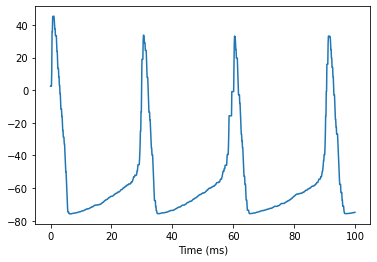

In [11]:
group3 = HH3(1, monitors=['V'])

group3.run(100.)

bp.visualize.line_plot(group3.mon.V_t, group3.mon.V, show=True)